In [3]:
import torch
import random
import pandas as pd
import numpy as np
import unicodedata
import re

import discopy
from discopy.symmetric import Ty, Box, Id, Functor
from discopy.grammar.pregroup import Word, Cup, Diagram
from discopy.drawing import Equation
from discopy.tensor import Dim, Tensor

from lambeq import BobcatParser
from lambeq import AtomicType, IQPAnsatz, remove_cups

In [4]:
SEED = 12
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

Dataset: https://github.com/CQCL/lambeq/tree/main/docs/examples/datasets

In [5]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t]) # to transform 0 to |0> and 1 to |1>
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('corpuses/mc/mc_train_data.txt')
dev_labels, dev_data = read_data('corpuses/mc/mc_dev_data.txt')
test_labels, test_data = read_data('corpuses/mc/mc_test_data.txt')

In [6]:
train_data[0], train_labels[0]

('skillful man prepares sauce .', [1.0, 0.0])

#### 1) First, define the atomic types "n" and "s".

In [7]:
# Parsing using lambeq
parser = BobcatParser(verbose='text')

In [8]:
raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


#### Create circuits

We will use an IQPAnsatz, where noun wires (n) are represented by a one-qubit system, and sentence wires (s) are discarded (since we deal with noun phrases).

Note that we remove the cups before parameterising the diagrams. By doing so, we reduce the number of post-selections, which makes the model computationally more efficient.

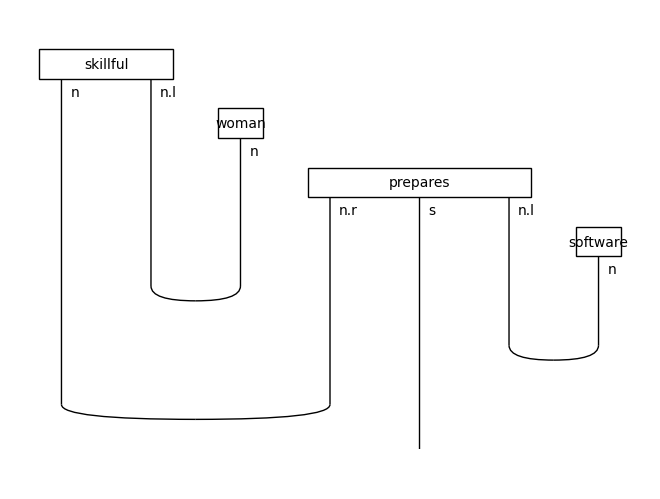

In [9]:
raw_test_diagrams[2].draw()

In [10]:
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

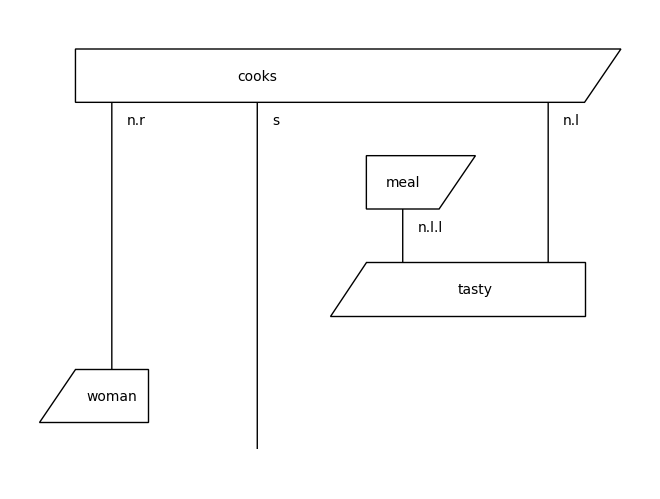

In [11]:
train_diagrams[2].draw()

In [12]:
N = AtomicType.NOUN
S = AtomicType.SENTENCE
ansatz = IQPAnsatz({N:1, S:1}, n_layers = 1, n_single_qubit_params=3) 
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]
test_circuits =  [ansatz(diagram)  for diagram in test_diagrams]

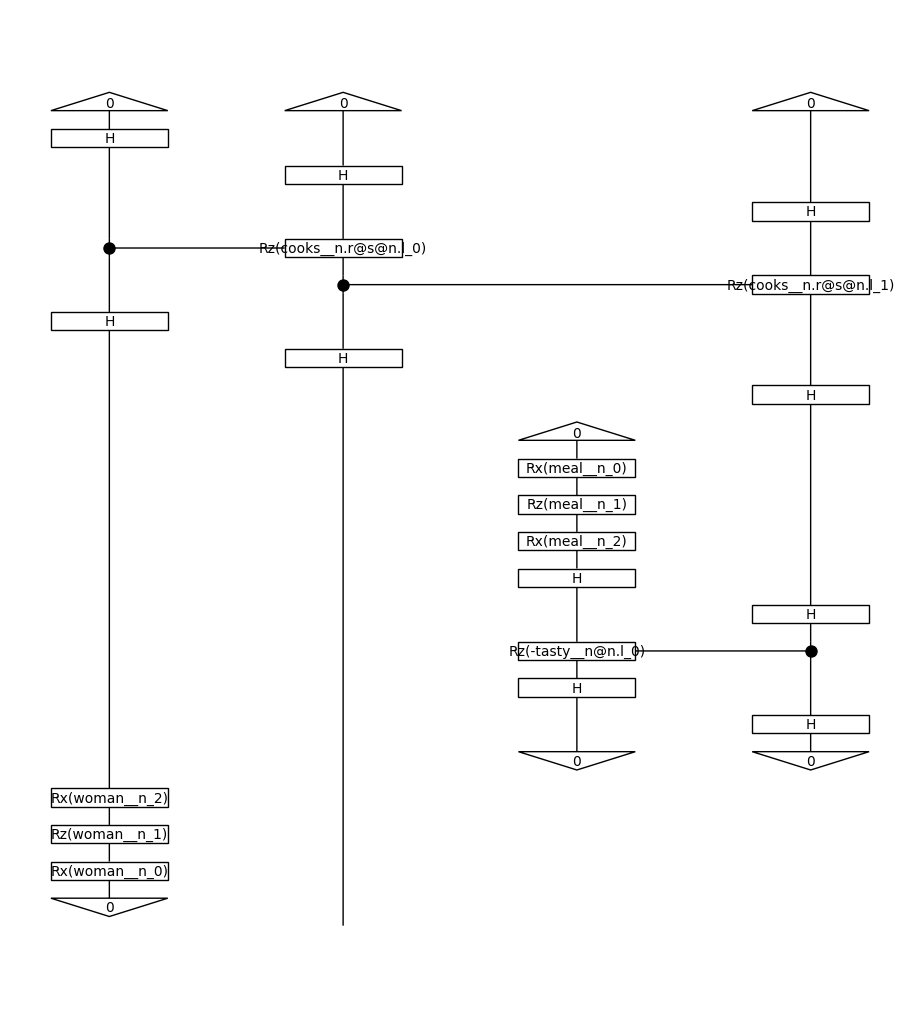

In [13]:
train_circuits[2].draw(figsize=(9, 10))

### Using Quantum Trainer

In [17]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

In [14]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

val_circuits = dev_circuits + test_circuits
all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [15]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [18]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

In [20]:
from lambeq import Dataset

val_labels = dev_labels + test_labels
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [21]:
trainer.fit(train_dataset, val_dataset, early_stopping_interval=10)

Epoch 1:    train/loss: 0.7848   valid/loss: 1.3489   train/acc: 0.5857   valid/acc: 0.6250
Epoch 2:    train/loss: 0.6500   valid/loss: 0.8389   train/acc: 0.5071   valid/acc: 0.5833
Epoch 3:    train/loss: 0.4570   valid/loss: 1.3689   train/acc: 0.5286   valid/acc: 0.6000
Epoch 4:    train/loss: 1.6211   valid/loss: 0.7645   train/acc: 0.6214   valid/acc: 0.6500
Epoch 5:    train/loss: 1.8744   valid/loss: 1.3809   train/acc: 0.5571   valid/acc: 0.4667
Epoch 6:    train/loss: 0.7436   valid/loss: 0.8925   train/acc: 0.5286   valid/acc: 0.5000
Epoch 7:    train/loss: 2.2108   valid/loss: 0.9598   train/acc: 0.4643   valid/acc: 0.6500
Epoch 8:    train/loss: 0.6545   valid/loss: 0.8553   train/acc: 0.6000   valid/acc: 0.6333
Epoch 9:    train/loss: 1.8760   valid/loss: 0.6958   train/acc: 0.6000   valid/acc: 0.6000
Epoch 10:   train/loss: 0.6826   valid/loss: 0.6727   train/acc: 0.5071   valid/acc: 0.5833
Epoch 11:   train/loss: 0.9376   valid/loss: 0.6669   train/acc: 0.5429   valid/

Validation accuracy: 0.6166666666666667


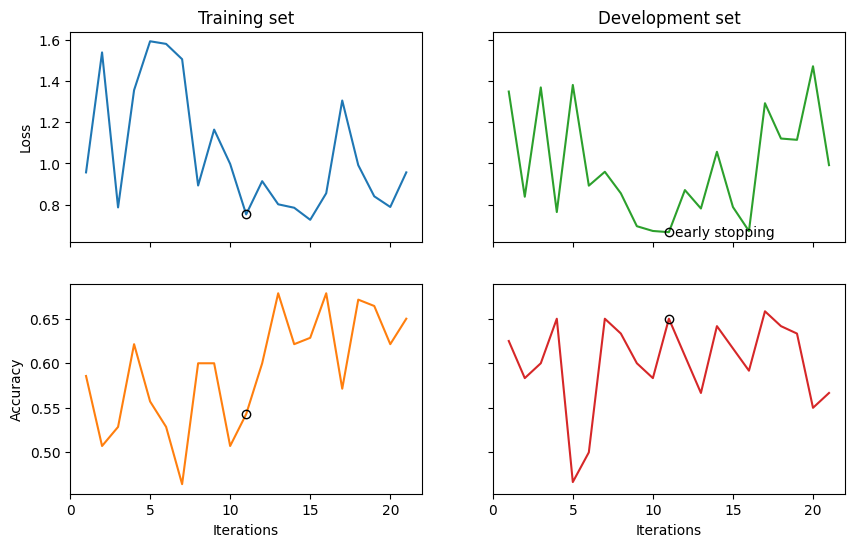

In [22]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmin(trainer.val_costs)
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_tr.text(best_epoch + 1.4, trainer.val_costs[best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())

### PennyLane model

In [23]:
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.01
SEED = 42

In [92]:
#!pip install PennyLane

In [24]:
from torch import nn
from lambeq import PennyLaneModel

In [25]:
all_circuits = train_circuits + dev_circuits + test_circuits
backend_config = {'backend': 'default.qubit'}
model2 = PennyLaneModel.from_diagrams(all_circuits, probabilities=True, normalize=True, backend_config=backend_config)
model2.initialise_weights()

In [26]:
#!pip install PennyLane-SF

In [27]:
#import pennylane as qml

#qml.default_config['qiskit.ibmq.ibmqx_token'] = '1de890a5571b4cc94c221554aa3ec8e4dc69e912dfbe0def31f77f4830ef7516b6de27a772d0f8b5e5b718d0c2fecec801677edaf70849fe83b07c32b42b0adc'
#qml.default_config.save(qml.default_config.path)
#backend_config = {'backend': 'qiskit.ibmq',
#                  'device': 'ibmq_manila',
#                  'shots': 1000}
#q_model = PennyLaneModel.from_diagrams(all_circuits,
#                                       probabilities=True,
#                                       normalize=True,
#                                       backend_config=backend_config)
#q_model.initialise_weights()

In [28]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_circuits, dev_labels)

In [29]:
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return nn.functional.mse_loss(y_hat, y)

In [30]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model2,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accuracy},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [31]:
trainer.fit(train_dataset, dev_dataset)

Epoch 1:   train/loss: 0.1586   valid/loss: 0.2152   train/acc: 0.6571   valid/acc: 0.6000
Epoch 2:   train/loss: 0.2104   valid/loss: 0.1727   train/acc: 0.7286   valid/acc: 0.7333
Epoch 3:   train/loss: 0.1347   valid/loss: 0.1478   train/acc: 0.8000   valid/acc: 0.8000
Epoch 4:   train/loss: 0.0326   valid/loss: 0.1251   train/acc: 0.8571   valid/acc: 0.8333
Epoch 5:   train/loss: 0.0636   valid/loss: 0.1120   train/acc: 0.9000   valid/acc: 0.8667
Epoch 6:   train/loss: 0.0239   valid/loss: 0.0978   train/acc: 0.9429   valid/acc: 0.8667
Epoch 7:   train/loss: 0.0049   valid/loss: 0.0847   train/acc: 0.9571   valid/acc: 0.9000
Epoch 8:   train/loss: 0.0360   valid/loss: 0.0750   train/acc: 0.9714   valid/acc: 0.9000
Epoch 9:   train/loss: 0.0045   valid/loss: 0.0669   train/acc: 0.9857   valid/acc: 0.9000
Epoch 10:  train/loss: 0.0009   valid/loss: 0.0584   train/acc: 1.0000   valid/acc: 0.9333
Epoch 11:  train/loss: 0.0118   valid/loss: 0.0514   train/acc: 1.0000   valid/acc: 0.9333

Final test accuracy: 0.9333333333333333


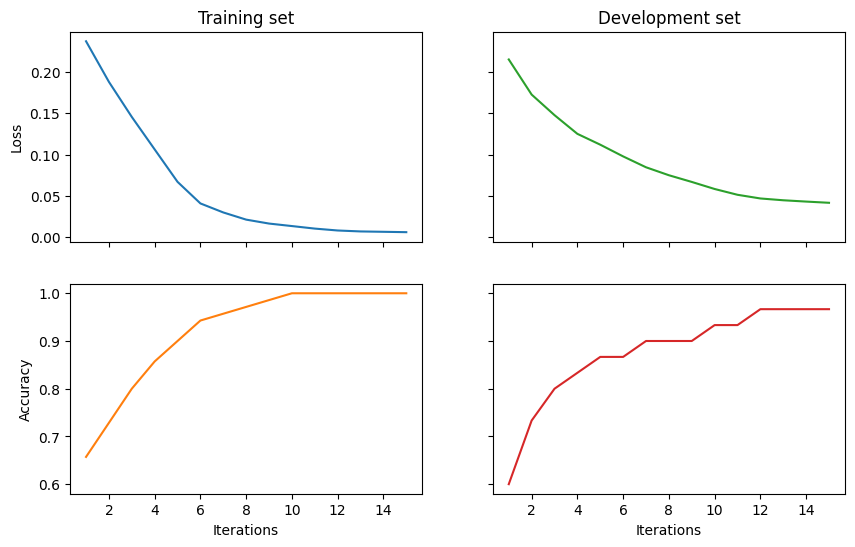

In [33]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model2(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(accuracy(pred, labels)))

In [ ]:
#PennyLaneModel.get_diagram_output(test_diagrams[0])
model.get_diagram_output(test_circuits)